In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random
from sklearn.cluster import KMeans

In [2]:
from src import CompositeMask
filename = 'Creatures-of-Comfort-spring-2018-look018.jpg'

In [3]:
cm = CompositeMask(filename, 0.3, 0.3, 16, 16)
#show an original runway image, resized to 200x300
cm.show_orig_image()

AttributeError: 'list' object has no attribute 'reshape'

In [4]:

def make_palette_uniform_width(colors, title=None, figsize=(8,4)):
    plt.figure(figsize=figsize)
    start = 0
    cur = start
    w = 1./len(colors)
    for c in colors:        
        plt.axvspan(cur, cur+w, color=c)
        cur += w
    if title is not None:
        plt.title(title)
    plt.axis([0, 1, 0, 1])
    plt.axis('off')
    plt.show()
        

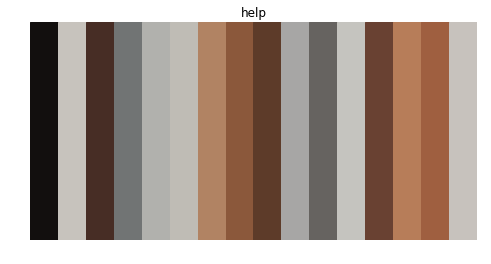

In [7]:
make_palette_uniform_width(cm.face_color_list, 'help')

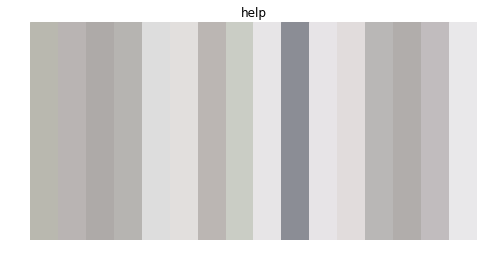

In [8]:
make_palette_uniform_width(cm.bg_color_list, 'help')

In [9]:
from sklearn.metrics.pairwise import euclidean_distances

def remove_bg_colors_from_face_pal(face_color_list, bg_color_list):
    temp_face = []
    for i, c1 in enumerate(cm.face_color_list):
        for j, c2 in enumerate(cm.bg_color_list):

            e = euclidean_distances(c1, c2)
            if e < 0.2:
                temp_face.append(c1)
    return [c for c in face_color_list if c not in temp_face]
                

In [10]:
tf = remove_bg_colors_from_face_pal(cm.face_color_list, cm.bg_color_list)

/Users/claremariemyers/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/claremariemyers/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/claremariemyers/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1,

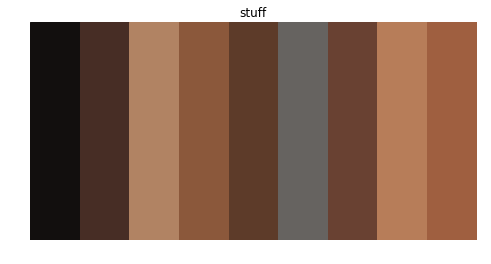

In [11]:
make_palette_uniform_width(tf, 'stuff')

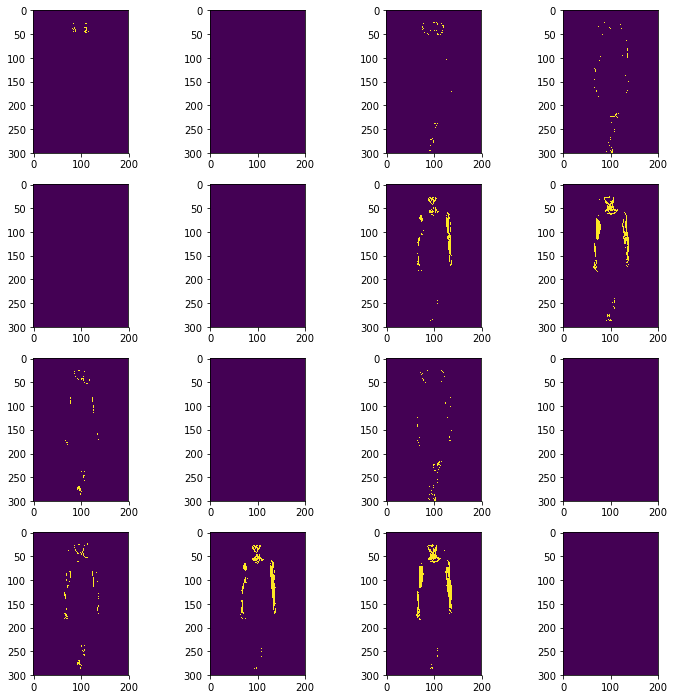

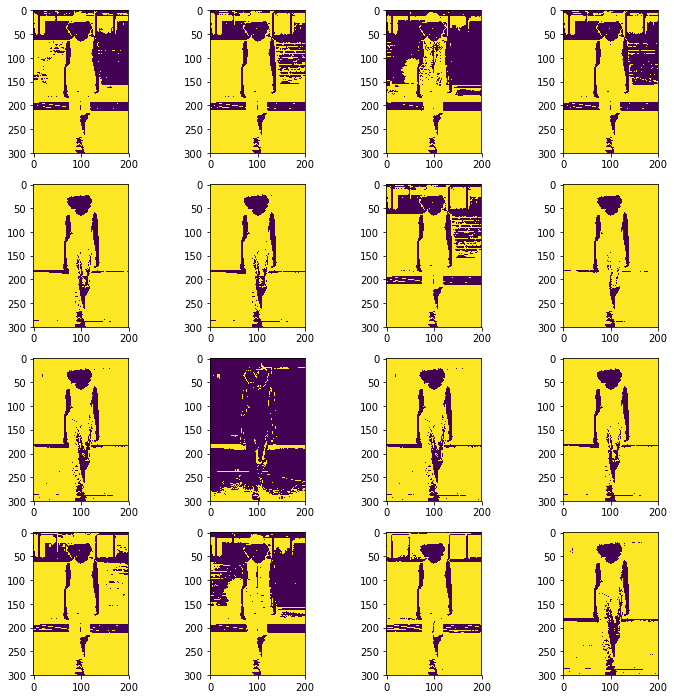

In [12]:
#take random samples from background (4x4 squares) and remove colors within that range from image
cm.plot_many_masks_face()
cm.plot_many_masks_bg()


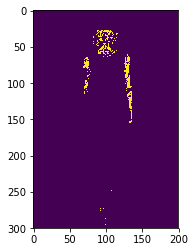

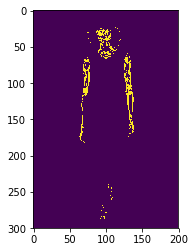

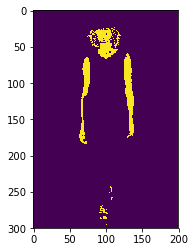

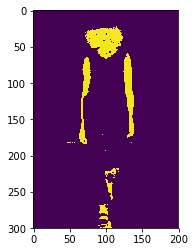

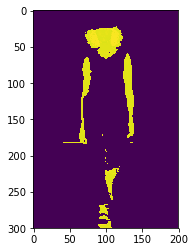

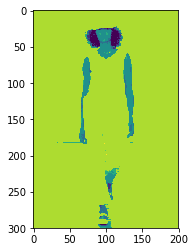

In [14]:
#combine all subtractions to create a composite mask
face_thresholds = [0.05, 0.1, 0.2, 0.4, 0.8, 1.6]
for t in face_thresholds:
    cm = CompositeMask(filename, 0.3, t, 16, 16)
    plt.imshow(cm.face_composite_mask)
    plt.show()

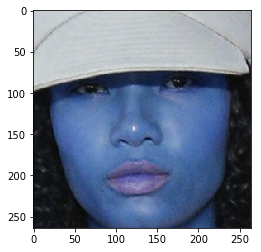

In [18]:
plt.imshow(cm.face)
plt.show()

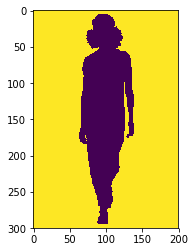

In [4]:
test = cm.make_boolean_mask(['accessories', 'skin', 'garment'])
plt.imshow(test)
plt.show()

In [5]:
cm.find_face_ratio()


0.051672597864768695

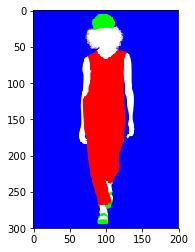

In [12]:
plt.imshow(cm.seg_image)
plt.show()

In [ ]:
def color_square_forw(color, title, figsize=(3,3)):



    plt.figure(figsize=figsize)
       
    plt.axvspan(0, 1, color=color)

    plt.title(title)
    plt.axis([0, 1, 0, 1])
    plt.axis('off')
    plt.show()

def color_square_backw(color, title, figsize=(3,3)):

    color = color[::-1]

    plt.figure(figsize=figsize)
       
    plt.axvspan(0, 1, color=color)

    plt.title(title)
    plt.axis([0, 1, 0, 1])
    plt.axis('off')
    plt.show()
    
    
color_square_backw(cm.face_color_list[0], 'stuff')
color_square_forw(cm.face_color_list[0], 'things')


In [ ]:
cm.face_color_list[0][0]

In [ ]:
cm.show_masked_image()



In [ ]:
#for testing, compare to a manually segmented image.
#This image has been separated into garment, hair/skin, accessories, and background. 
#However, at this point I am only trying to isolate the figure from the background
seg_img = CompositeMask(seg_img).image
plt.imshow(seg_img)
plt.show()





In [ ]:
#use OpenCV create a boolean mask by identifying all blue areas of the image
#true blue is [0, 0, 255]; we want to catch a range just in case
def make_boolean_mask(segmented_img):
    low_bg = np.array([0, 0, 250])
    high_bg = np.array([5, 5, 255])
    return cv2.inRange(segmented_img, low_bg, high_bg)



In [ ]:
bg_is_255 = make_boolean_mask(seg_img)
plt.imshow(bg_is_255)
plt.show()

In [ ]:
def cleanup_comp_mask(comp_mask):
    temp = np.array([255 if p > 127 else 0 for p in comp_mask.flatten()])
    return temp.reshape(300, 200)

#push any noisy pixels to 255 or 0
clean_comp_mask = cleanup_comp_mask(cm.full_composite_mask)
plt.imshow(clean_comp_mask)
plt.show()


In [ ]:
def build_comp_image_and_confusion_dict(image_mask, manual_mask):
    '''
    compares predictions (composite mask) to truth (segmented mask)
    returns a new image with 4 levels: 255 for true background predictions 
                                       200 for figure predicted to be background
                                       100 for background predicted to be figure
                                       0 for true figure predictions
    
    a dict represention of a confusion matrix
    '''
    
    confusion_dict = {'true_bg_pred_bg': 0, 'true_bg_pred_fig': 0, 'true_fig_pred_bg': 0, 'true_fig_pred_fig': 0}
    new_image = []
    for row_manual, row_cm in zip(manual_mask, image_mask):
        for item_manual, item_cm in zip(row_manual, row_cm):
            if item_manual == item_cm :
                if item_manual == 255:
                    new_image.append(255)
                    confusion_dict['true_bg_pred_bg'] += 1
                else: 
                    new_image.append(0) 
                    confusion_dict['true_fig_pred_fig'] += 1
            else: 
                if item_manual > 200:
                    new_image.append(100)
                    confusion_dict['true_bg_pred_fig'] += 1
                else: 
                    new_image.append(200)
                    confusion_dict['true_fig_pred_bg'] += 1
                    
    return np.array(new_image).reshape(300, 200), confusion_dict
    

In [ ]:
im, cd = build_comp_image_and_confusion_dict(clean_comp_mask, bg_is_255)
plt.imshow(im)
plt.show()

In [ ]:
print cd

In [ ]:
def get_comparison_metrics(confusion_dict):
    accuracy = (confusion_dict['true_bg_pred_bg'] + confusion_dict['true_fig_pred_fig']) / 60000.0
    precision_of_fig = (confusion_dict['true_fig_pred_fig'] + 1)*1. / \
            (confusion_dict['true_bg_pred_fig'] + confusion_dict['true_fig_pred_fig'] + 1)
    recall_of_fig = (confusion_dict['true_fig_pred_fig'] + 1)*1. / \
        (confusion_dict['true_fig_pred_bg'] + confusion_dict['true_fig_pred_fig'] + 1)
    harmonic_mean = 2.*(precision_of_fig * recall_of_fig) / (precision_of_fig + recall_of_fig)
    string_out = 'accuracy: ' + str(accuracy) + '\n'
    string_out += 'precision: ' + str(precision_of_fig) + '\n'
    string_out += 'recall: ' + str(recall_of_fig) + '\n'
    string_out += 'harmonic mean: ' + str(harmonic_mean)
    return accuracy, precision_of_fig, recall_of_fig, harmonic_mean, string_out
    

In [ ]:
print get_comparison_metrics(cd)[4]

In [ ]:
def from_paths_to_conf_dict(path_to_orig, path_to_manual_seg, threshold, num_bg_pts):
    
    fig = plt.figure(figsize=(8, 3))
    
    #create composite mask object
    cm = CompositeMask(path_to_orig, threshold, num_bg_pts)
    comp_mask = cleanup_comp_mask(cm.full_composite_mask)
    fig.add_subplot(131)
    plt.imshow(comp_mask)
    #plt.show()

    
    man_seg_img = CompositeMask(path_to_manual_seg).image
    manual_seg_mask = make_boolean_mask(man_seg_img)
    fig.add_subplot(132)
    plt.imshow(manual_seg_mask)
    #plt.show()
    
    truth_img, conf_dict = build_comp_image_and_confusion_dict(comp_mask, manual_seg_mask)
    acc, prec, rec, harm, string_out = get_comparison_metrics(conf_dict)
    fig.add_subplot(133)
    plt.imshow(truth_img)
    plt.show()
    
    print string_out
    
    return acc, prec, rec, harm


    
    
    

In [ ]:
from_paths_to_conf_dict(test_img, seg_img, 0.3, 16)

In [ ]:
dicts_by_threshold = {}

for t in [0.1, 0.3, 0.5, 0.7, 0.9]:
    print '\nfor threshold {}'.format(t)
    acc, prec, rec, harm = from_paths_to_conf_dict(test_img, \
                        seg_img, t, 16)
    dicts_by_threshold[t] = {'accuracy': acc, 'precision': prec, 'recall': rec}
    
    
    

In [ ]:
dicts_by_threshold = {}

for t in [0.05, 0.1, 0.15]:
    print '\nfor threshold {}'.format(t)
    acc, prec, rec, harm = from_paths_to_conf_dict(test_img, \
                        seg_img, t, 16)
    dicts_by_threshold[t] = {'accuracy': acc, 'precision': prec, 'recall': rec}
    
    
    

In [ ]:
dicts_by_bg_pts = {}

for n in [4, 8, 16, 32]:
    print '\nfor num bg points {}'.format(n)
    acc, prec, rec, harm = from_paths_to_conf_dict(test_img, \
                        seg_img, 0.05, n)
    dicts_by_bg_pts[n] = {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': harm}
    
    

In [ ]:
def search_for_best_thresh(test_img, seg_img, thresh_list):
    maxf1 = 0
    best_t = 0
    for t in thresh_list:
        acc, prec, rec, harm = from_paths_to_conf_dict(test_img, seg_img, t, 16)
        if harm > maxf1:
            maxf1 = harm
            best_t = t
    return best_t
        
    

In [ ]:
best_t = search_for_best_thresh(test_img, seg_img, [0.2, 0.4, 0.6, 0.8, 1.0])

In [ ]:
def make_thresh_list(thresh, iteration):
    min_t = thresh - thresh*(1./iteration)
       
    max_t = thresh + thresh*(1./iteration)
    print "min and max ", min_t, max_t
    return np.linspace(min_t, max_t, 5)


In [ ]:


list_of_bests = []
for i in range(3):
    best_t = search_for_best_thresh(test_img, seg_img, [0.2, 0.4, 0.6, 0.8, 1.0])
    for j in range(2,5):
        print "best threshold so far ", best_t
        next_t = make_thresh_list(best_t, j)
        print "what I will search on next ", next_t
        best_t = search_for_best_thresh(test_img, seg_img, next_t)
    list_of_bests.append(best_t)
    
    

In [ ]:
list_of_bests

Face stuff!

In [ ]:
cm.face_color_list

In [ ]:
plt.imshow(cm.face_composite_mask)
plt.show()

In [ ]:
plt.imshow(cm.full_composite_mask)
plt.show()

In [ ]:
plt.imshow(cm.bg_composite_mask)
plt.show()

In [ ]:
cm.plot_many_masks_face()

In [ ]:
dicts_by_bg_pts

In [ ]:
plt.plot([d['accuracy'] for d in sorted(dicts_by_bg_pts.values())], label='accuracy')
plt.plot([d['precision'] for d in sorted(dicts_by_bg_pts.values())], label='precision')
plt.plot([d['recall'] for d in sorted(dicts_by_bg_pts.values())], label='recall')

plt.xticks(range(len(dicts_by_bg_pts.keys())), sorted(dicts_by_bg_pts.keys()))


plt.legend()
plt.show()

In [ ]:
dicts_by_threshold

In [ ]:
plt.plot([d['accuracy'] for d in sorted(dicts_by_threshold.values())], label='accuracy')
plt.plot([d['precision'] for d in sorted(dicts_by_threshold.values())], label='precision')
plt.plot([d['recall'] for d in sorted(dicts_by_threshold.values())], label='recall')

plt.xticks(range(len(dicts_by_threshold.keys())), sorted(dicts_by_threshold.keys()))


plt.legend()
plt.show()

In [ ]:
dicts_by_thresh_grid = {}
for t in [0.5, 0.7, 0.9]:
    dicts_by_thresh_grid[t] = {} 
    print 'for threshhold {}\n'.format(t)
    for n in [8, 12, 16, 20]:
        print 'for num points {}'.format(n)
        acc, prec, rec = from_paths_to_conf_dict(test_img, \
                        seg_img, 0.4, n)
        dicts_by_thresh_grid[t][n] = {'accuracy': acc, 'precision': prec, 'recall': rec}
        

In [ ]:
dicts_by_thresh_grid

In [ ]:
accuracy = (confusion_dict['true_bg_pred_bg'] + confusion_dict['true_fig_pred_fig']) / 60000.0
accuracy

In [ ]:
precision_of_fig = (confusion_dict['true_fig_pred_fig'])*1. / \
            (confusion_dict['true_bg_pred_fig'] + confusion_dict['true_fig_pred_fig'])
precision_of_fig

In [ ]:
recall_of_fig = (confusion_dict['true_fig_pred_fig'])*1. / \
        (confusion_dict['true_fig_pred_bg'] + confusion_dict['true_fig_pred_fig'])
recall_of_fig

In [ ]:
def get_background_one_image(filepath, num_points = 16):
    background_colors = []
    im = plt.imread(filepath)
    im = np.array(im, dtype=np.float64) / 255

    h, w, colors = im.shape

    for i in range(int(num_points/2)):
        row = np.random.choice(h)
        col = np.random.choice(xrange(int(w/8)))
        color_block = im[int(row-4):int(row+4), int(col-4):int(col+4)]
        ave_color = [avg_each_color(color_block, color) for color in ['r', 'g', 'b']]
        background_colors.append(ave_color)
    for i in range(int(num_points/2)):
        row = np.random.choice(h)
        col = np.random.choice(xrange(int((7*w/8)), w))
        color_block = im[int(row-4):int(row+4), int(col-4):int(col+4)]
        ave_color = [avg_each_color(color_block, color) for color in ['r', 'g', 'b']]
        background_colors.append(ave_color)

    return background_colors

def avg_each_color(color_block, color):
    color_dict = {'r':0, 'g':1, 'b':2}
    index = color_dict[color]
    all_colors = [color[index] for row in color_block for color in row]
    ave_color = sum(all_colors)/(len(all_colors) + 1)
    return ave_color

In [ ]:
cm = CompositeMask('data/Alexander-Wang-spring-2018-look077.jpg', 1, 16)
cm.show_orig_image()



In [ ]:
cm.plot_many_masks()

In [ ]:
cm.show_masked_image()

In [ ]:
#going to play with contours

In [ ]:
plt.imshow(cm.composite_mask)
plt.show()

In [ ]:
lower = 0
upper = 15
shapeMask = cv2.inRange(cm.composite_mask, lower, upper)

contoured_img, contours, hierarchy = \
                    cv2.findContours(shapeMask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    

In [ ]:
for c in contours:
    #looking for contours that are at least 10% the size of the total image. This needs to be explored further.
    if cv2.contourArea(c) > .1*cm.image.shape[0]*cm.image.shape[1]:
        cv2.drawContours(cm.image, [c], 0, (255, 255, 0), 3)    
        plt.imshow(bgr_to_rgb(cm.image.copy()))
        plt.show()
        
    

In [ ]:
for im in os.listdir('data/'):
    if im.endswith('jpg'):
        cm = CompositeMask('data/' + im)
        cm.show_orig_image()
        cm.show_masked_image()

#todo: turn output into grid

In [ ]:
lower = 0
upper = 15

for im in os.listdir('data/'):
    if im.endswith('jpg'):
        cm = CompositeMask('data/' + im)
        shapeMask = cv2.inRange(cm.composite_mask, lower, upper)
        contoured_img, contours, hierarchy = \
                    cv2.findContours(shapeMask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # loop over the contours
    largest_contour = max(cv2.contourArea(cnt) for cnt in contours)
    for c in contours:
        # draw the contour and show it
        if cv2.contourArea(c) == largest_contour:
            cv2.drawContours(cm.image, [c], 0, (255, 255, 0), 5)    
            plt.imshow(bgr_to_rgb(cm.image.copy()))

        plt.show()


        

In [ ]:
#thoughts: separate top from bottom
#explore more about the findContours arguments
#make some ground truth images

In [ ]:
#now let's look at various different thresholds

In [ ]:
def plot_mask_and_contour(path, threshold):
    fig, axs = plt.subplots(1,3)
    cmx = CompositeMask(path, threshold=threshold)
    axs[0].imshow(bgr_to_rgb(cmx.image))
    axs[1].imshow(cmx.masked_image)
    contour_plot(cmx, axs[2])
    plt.tight_layout()
    plt.show()
    
    
def contour_plot(cm_object, ax, lower=0, upper=15):
    shapeMask = cv2.inRange(cm_object.composite_mask, lower, upper)
    contoured_img, contours, hierarchy = \
                    cv2.findContours(shapeMask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # loop over the contours
    areas = [cv2.contourArea(cnt) for cnt in contours]
    if len(areas) > 0:
        largest_contour = max(cv2.contourArea(cnt) for cnt in contours)
        for c in contours:
            # draw the contour and show it
            if cv2.contourArea(c) == largest_contour:
                cv2.drawContours(cm_object.image, [c], 0, (255, 255, 0), 5)    
                ax.imshow(bgr_to_rgb(cm_object.image.copy()))


    
    

In [ ]:
thresh = [0.1, 0.3, 0.5, 1.0]
for im in os.listdir('data/'):
    if im.endswith('jpg'):
        for t in thresh:
            plot_mask_and_contour('data/' + im, t)

            


In [ ]:
#figure out how to fill in everything that is outside the contour

In [ ]:
def get_std_devs(image):
    color_indicators = ['b', 'g', 'r']
    std_devs = {}
    
    for color, ci in zip(cv2.split(image), color_indicators):
        std_dev_color = []
        count = 0
        trans = color.T
        for row in trans:
            std_dev_color.append(np.std(row))
        std_devs[ci] = std_dev_color
        
        
    return std_devs

def plot_std_devs(sd_dict):
    color_indicators = ['b', 'g', 'r']
    for l, ci in zip(sd_dict.values(), color_indicators):
        plt.scatter(xrange(len(l)), l, c=ci)
        plt.show()
         
    
        

          

In [ ]:
cm01 = CompositeMask('data/Alexander-Wang-spring-2018-look077.jpg')
plot_std_devs(get_std_devs(cm01.image))


In [ ]:
from scipy.signal import argrelextrema

im01std_devs = get_std_devs(cm01.image)

x = np.random.random(12)

# for local maxima
argrelextrema(x, np.greater)

# for local minima
argrelextrema(x, np.less)


for color, std_devs in im01std_devs.iteritems():
    local_maxes = argrelextrema(np.array(std_devs), np.greater)
    print local_maxes

In [ ]:
def diffs(array):
    diffs = []
    for i, j in zip(array, array[1:]):
        diffs.append(j - i)
    return np.array(diffs)

In [ ]:
dfs1 = diffs(im01std_devs.values()[0])
plt.scatter(xrange(len(dfs1)), dfs1)
plt.show()


In [ ]:
x = np.arange(len(dfs1)) 
y = dfs1
rft = np.fft.rfft(y)
rft[2:] = 0   # Note, rft.shape = 21
y_smooth = np.fft.irfft(rft)


plt.scatter(x[::5], y[::5], label='Original')
plt.plot(x[:-1], y_smooth, label='Smoothed', c='r')
plt.legend(loc=0).draggable()
plt.show()

In [ ]:
class CompositeMask():
    def __init__(self, path, threshold = 0.4, num_bg_colors = 16):
        self.load_and_resize_image(path)
        bg_pal = get_background_one_image(path, num_bg_colors)
        self.color_list = [[c[2], c[1], c[0]] for c in bg_pal]
        self.threshold = threshold
        self.make_many_masks()
        self.composite_mask = sum(self.masks)
        self.make_masked_image()
        
    def load_and_resize_image(self, path):
        im = plt.imread(path)
        size = im.shape       
        r = 200.0 / im.shape[1]
        dim = (200, int(im.shape[0] * r))
        resized = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)
        im = rgb_to_bgr(resized)
        self.image = im

    def make_mask(self, three_colors):
        lower = np.array([(c - self.threshold*c)*255 for c in three_colors])
        upper = np.array([(c + self.threshold*c)*255 for c in three_colors])
        shapeMask = cv2.inRange(self.image, lower, upper)
        contoured_img, contours, hierarchy = \
                            cv2.findContours(shapeMask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        return contoured_img
    
    def make_many_masks(self):  
        self.masks = []
        for three_colors in self.color_list:
            self.masks.append(self.make_mask(three_colors))
            
    def plot_many_masks(self):
        num_bg_colors = len(self.masks)
        num_rows = int(num_bg_colors/4) + 1
        subplot_location = 0
        fig = plt.figure(figsize=(10, 12))
        for m in self.masks:
            subplot_location += 1
            ax = fig.add_subplot(num_rows, 4, subplot_location)
            ax.imshow(m)
        plt.tight_layout()
        plt.show()
 
    def make_masked_image(self):
        orig_shape = self.image.shape
        new_image = []
        flat_mask = [p for row in self.composite_mask for p in row]
        flat_image = [p for row in self.image for p in row]
        for m, p in zip(flat_mask, flat_image):
            if m != 0:
                new_image.append(np.array([57, 255, 20]))
            else: new_image.append(p)
        new_image = np.array(new_image)
        new_image = new_image.reshape(orig_shape)
        new_image = new_image.astype('uint8')
        new_image = bgr_to_rgb(new_image)
        self.masked_image = new_image

    def show_masked_image(self):
        im_rgb = self.masked_image
        plt.imshow(im_rgb)
        plt.show()
        
    def show_orig_image(self):
        im_rgb = bgr_to_rgb(self.image)
        plt.imshow(im_rgb)
        plt.show()
  






In [ ]:
local_maxes = argrelextrema(y_smooth, np.greater)
local_mins = argrelextrema(y_smooth, np.less)

In [ ]:
local_maxes, local_mins

In [ ]:
plt.imshow(bgr_to_rgb(cm01.image))
for ix in np.concatenate([local_maxes[0], local_mins[0]]):
    plt.axvline(ix, c='b')
plt.show()

In [ ]:
def draw_std_lines(image):
    stds_dict = get_std_devs(image)
    plt.imshow(bgr_to_rgb(image))
    for color, sds in stds_dict.iteritems():
        dfs = diffs(sds)
        y_smooth = smooth_sds(dfs)
        local_extrema = get_local_extrema(y_smooth)
        for ix in local_extrema:
            plt.axvline(ix, c=color)
                
def smooth_sds(std_dev_list):
    rft = np.fft.rfft(std_dev_list)
    rft[2:] = 0
    y_smooth = np.fft.irfft(rft)
    return y_smooth

def get_local_extrema(smoothed_list):
    #this assumes we are doing one max and one min
    lmax = argrelextrema(smoothed_list, np.greater)[0][0]
    lmin = argrelextrema(smoothed_list, np.less)[0][0]
    
    return [lmax, lmin]

def diffs(array):
    diffs = []
    for i, j in zip(array, array[1:]):
        diffs.append(j - i)
    return np.array(diffs)

In [ ]:
draw_std_lines(cm01.image)

In [ ]:
plt.show()

In [ ]:
for im in os.listdir('data/'):
    if im.endswith('jpg'):
        cm = CompositeMask('data/' + im)
        cm.show_orig_image()
        plot_std_devs(cm.image)
        

In [ ]:
for f in os.listdir('data/'):
    if f.endswith('jpg'):
        cm = CompositeMask('data/' + f)
        draw_std_lines(cm.image)
        plt.show()

In [ ]:
def plot_std_devs_top_to_bottom(image):
    color_indicators = ['b', 'g', 'r']
    std_dev_sum = np.zeros(image.shape[0])
    for color, ci in zip(cv2.split(image), color_indicators):
        std_dev_color = []
        count = 0

        for row in color:
            std_dev_color.append(np.std(row))
        std_dev_sum += std_dev_color
        plt.scatter(std_dev_color, xrange(len(std_dev_color)), c=ci)
        plt.gca().invert_yaxis()
        plt.show()
    plt.scatter(std_dev_sum, xrange(len(std_dev_sum)), c='k')
    plt.gca().invert_yaxis()
    plt.show()
    
    

    

In [ ]:
cm01 = CompositeMask('data/Alexander-Wang-spring-2018-look077.jpg')
cm01.show_orig_image()
plot_std_devs_top_to_bottom(cm01.image)

In [ ]:
for im in os.listdir('data/'):
    if im.endswith('jpg'):
        cm = CompositeMask('data/' + im)
        cm.show_orig_image()
        plot_std_devs_top_to_bottom(cm.image)
        

In [ ]:
# I want to play with kmeans. Why? Compare this to background sampling. Just take an image and replot is in 32 colors

In [ ]:
def flatten_image(image):
    im = np.array(image, dtype=np.float64) / 255    
    w, h, colors = im.shape
    image_flat = np.reshape(im, (w * h, colors))
    return image_flat
    

def kmeans_palette_one_image(image, n_colors, sample_size = 500, seed = 17):
    image = flatten_image(image)        
    if len(image) > sample_size:
        sample_size = len(image)        
    random.seed(seed)
    sample = random.sample(image, sample_size)

    return KMeans(n_clusters=n_colors, random_state=seed).fit(sample)

def assign_kmeans_clusers(image, kmeans_object):
    image = flatten_image(image)    
    predictions = kmeans_object.predict(image)
    return predictions

def assign_colors_to_predictions(kmeans_object, predictions):
    return [kmeans_object.cluster_centers_[ix] for ix in predictions]

def reshape_color_predictions(orig_image, color_predicts):
    w, h, colors = orig_image.shape
    return np.array(color_predicts).reshape(w, h, colors)


In [ ]:
kmeans = kmeans_palette_one_image(cm.image, 4)
preds = assign_kmeans_clusers(cm.image, kmeans)

In [ ]:
color_preds = assign_colors_to_predictions(kmeans, preds)

In [ ]:
kmeans_image = reshape_color_predictions(cm.image, color_preds)


In [ ]:
plt.imshow(bgr_to_rgb(kmeans_image))
plt.show()

In [ ]:
def make_kmeans_image(image, num_cols):
    kmeans = kmeans_palette_one_image(image, num_cols)
    preds = assign_kmeans_clusers(image, kmeans)
    color_preds = assign_colors_to_predictions(kmeans, preds)
    kmeans_image = reshape_color_predictions(image, color_preds)
    plt.imshow(bgr_to_rgb(kmeans_image))

In [ ]:
for f in os.listdir('data/'):
    if f.endswith('jpg'):
        cm = CompositeMask('data/' + f)
        make_kmeans_image(cm.image, 2)
        plt.show()

In [ ]:
for f in os.listdir('data/'):
    if f.endswith('jpg'):
        cm = CompositeMask('data/' + f)
        im = make_kmeans_image(cm.image, 4)
        print type(im)
        plt.show()

In [ ]:
for f in os.listdir('data/'):
    if f.endswith('jpg'):
        cm = CompositeMask('data/' + f)
        make_kmeans_image(cm.image, 6)
        plt.show()

In [ ]:
for f in os.listdir('data/'):
    if f.endswith('jpg'):
        cm = CompositeMask('data/' + f)
        make_kmeans_image(cm.image, 8)
        plt.show()

In [ ]:
for f in os.listdir('data/'):
    if f.endswith('jpg'):
        cm = CompositeMask('data/' + f)
        grey_image = cv2.cvtColor(cm.image, cv2.COLOR_RGB2GRAY)
        print grey_image.shape
        plt.imshow(grey_image)
        plt.show()